### Tools for reading the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from IPython.display import display, JSON, clear_output

In [2]:
from optosim.simulation.event_reader import EventReader, show_data
import pandas as pd


#### Check all available data

In [4]:
data_dir = '/data/xenon/optosim/data'
show_data(data_dir)

Found 9 subdirectories
Subdirectories:
['mc0006', 'mc0007', 'mc0010', 'mc0011', 'mc0012', 'test_mc0000', 'test_mc0001', 'test_mc0002', 'test_mc0003']
File /data/xenon/optosim/data/test_mc0003/test_mc0003.0000.hdf5 is currently open by another process. Skipping...


,subdir,detector,nevents,nphoton_per_event,scatter,experimental_scatter_model,radius
0,mc0006,XAMS,10000,"[1000, 25000]",NaN,NaN,3.2
1,mc0007,XENONnT,10000,"[1000, 25000]",NaN,NaN,65.0
2,mc0010,XAMS,10000,"[100, 100000]",True,True,3.2
3,mc0011,XAMS,10000,"[100, 100000]",True,False,3.2
4,mc0012,XAMS,10000,"[100, 100000]",False,NaN,3.2


#### Get all the file names and initialize the data reader class

In [5]:
files = glob.glob('/data/xenon/optosim/data/mc0010/mc0010.000*.hdf5')
print(files)

['/data/xenon/optosim/data/mc0010/mc0010.0001.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0008.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0007.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0000.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0006.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0003.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0004.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0005.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0009.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0002.hdf5']


#### Loop over the events

1. maximum number of events can be set with nmax
2. use plot=True to show the events 

Note: the event loop below assumes a 2x2 detector. For other dimensions the code needs to be adapted

In [6]:
nmax=1000000

In [7]:
%%time
events = EventReader(files)


huh config =  {'detector': 'XAMS', 'nevents': 10000, 'nphoton_per_event': [100, 100000], 'photon_zgen': 0.5, 'geometry': {'type': 'cylinder', 'radius': 3.2, 'ztop': 1.2, 'zliq': 0.0, 'zbot': -6.7, 'ptfe_zmin': -5.32, 'ptfe_zmax': -0.25}, 'npmt_xy': 2, 'pmt': {'type': 'square', 'size': 2.54, 'ndivs': 10}, 'scatter': True, 'experimental_scatter_model': True, 'data_type_version': 2.0}
EventReader initialized with:
  number of files:  10
  number of events:  100000
  configuration:  {'detector': 'XAMS', 'nevents': 10000, 'nphoton_per_event': [100, 100000], 'photon_zgen': 0.5, 'geometry': {'type': 'cylinder', 'radius': 3.2, 'ztop': 1.2, 'zliq': 0.0, 'zbot': -6.7, 'ptfe_zmin': -5.32, 'ptfe_zmax': -0.25}, 'npmt_xy': 2, 'pmt': {'type': 'square', 'size': 2.54, 'ndivs': 10}, 'scatter': True, 'experimental_scatter_model': True, 'data_type_version': 2.0}
processed  0 events
processed  1000 events
processed  2000 events
processed  3000 events
processed  4000 events
processed  5000 events
processed 

In [10]:
plot=False


# this if where the data goes....
data_dict = { 
    'x': [],
    'y': [],
    'q_b': [],
    'q_l': [],
    'q_tot': []
}

#
# loop over evnts...
#
for i in range(events.num_events):

    ev = events.get_event(i)

    if i%10000 == 0:
        print('processed ',i,'events')#, events.print_event(ev))
    
    # if you want to show the events
    if plot:
        nph = ev['nphoton']
        
        if nph < 2000000:
            print('nphoton = ',nph)

            events.show_event(i)
            response = input("Press Enter to continue to the next event or 'q' to quit...")

            if response.lower() == 'q':
                print("Quit the event display......")
                break
        
            clear_output(wait=True)
    
    
    # retrieve the true hit position
    x_true = ev['true_position']
    data_dict['x'].append(x_true[0])
    data_dict['y'].append(x_true[1])
    
    # get the data from the top PMT    
    pmt = ev['pmt_top']
    qtot = float(np.sum(pmt))
    data_dict['q_b'].append((pmt[0][0] + pmt[1][0]))
    data_dict['q_l'].append((pmt[0][0] + pmt[0][1]))
    data_dict['q_tot'].append(qtot)
    
    if n>nmax:
        break
            
# write the data to a dataFrame
df = pd.DataFrame(data_dict)
df['r'] = np.sqrt(df['x']**2+df['y']**2)
df['q_tb'] = df['q_b']/df['q_tot']
df['q_lr'] = df['q_l']/df['q_tot']

processed  0 events
processed  10000 events
processed  20000 events
processed  30000 events
processed  40000 events
processed  50000 events
processed  60000 events
processed  70000 events
processed  80000 events
processed  90000 events


#### Plot the charge ratio

Two plots: (i) $Q_L / Q_{tot}$ as a function of $x$ (ii) $Q_B / Q_{tot}$ as a function of $y$.

Text(0, 0.5, '$Q_B / Q_{tot}$')

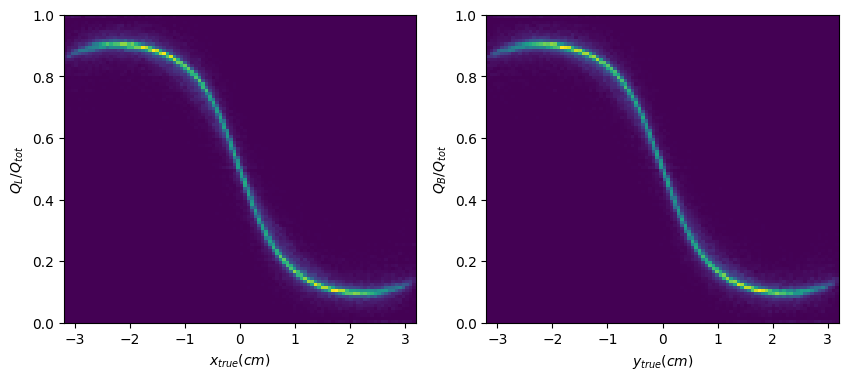

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(df['x'],df['q_lr'],bins=(100,100), range=((-R,R),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(df['y'],df['q_tb'],bins=(100,100), range=((-R,R),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')

Text(0, 0.5, '$Q_B$')

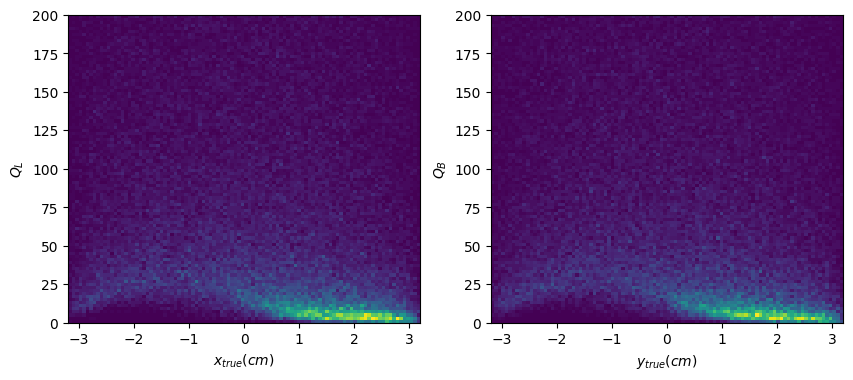

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(df['x'],df['q_l'],bins=(100,100), range=((-R,R),(0,200)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L$')

h2 = axs[1].hist2d(df['y'],df['q_b'],bins=(100,100), range=((-R,R),(0,200)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B$')

.... and also $Q_{tot}$ as a function of radius.

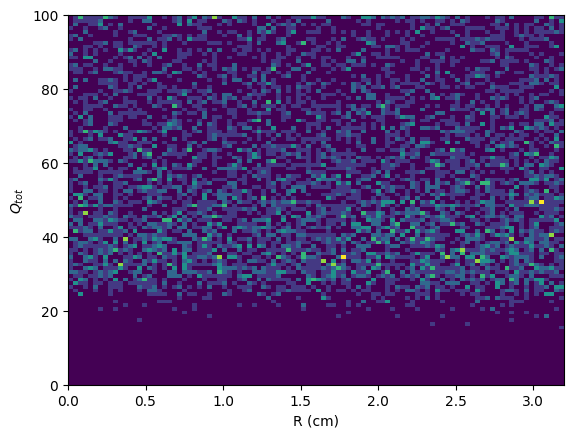

In [15]:

R = events.config['geometry']['radius']

r2 = np.sqrt(df['x']**2+df['y']**2)
h=plt.hist2d(r2*r2,df['q_tot'],bins=100, range=((0,R),(0,100)))
plt.xlabel('R (cm)')
plt.ylabel('$Q_{tot}$')
plt.show()

In [ ]:
import numpy as np
# I want to open the hdf5 files and read the data
import h5py
import matplotlib.pyplot as plt
import glob
from IPython.display import display, JSON, clear_output

# this is the directory where the data is stored
files = glob.glob('/data/xenon/optosim/data/mc0010/mc0010.*.hdf5')
print(files)

with h5py.File(files[0], 'r') as f:
    config = f.attrs['config']

    all_fine_bot = f['events/fine_bot'][:]

print(all_fine_bot.shape)

print(all_fine_bot[0])


file = files[0]

['/data/xenon/optosim/data/mc0010/mc0010.0001.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0008.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0007.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0000.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0006.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0003.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0004.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0005.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0009.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0017.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0019.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0018.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0002.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0020.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0013.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0022.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0010.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0028.hdf5', '/data/xenon/optosim/data/mc0010/mc0010.0024.hdf5', '/data/xeno

In [ ]:
import h5py

def print_structure(file, indent=''):
    for key, item in file.items():
        if isinstance(item, h5py.Dataset):
            print(indent + key + ": Dataset")
        elif isinstance(item, h5py.Group):
            print(indent + key + ": Group")
            print_structure(item, indent + '  ')
        print_attributes(item, indent + '  ')

def print_attributes(item, indent):
    attrs = item.attrs
    for attr_name, attr_value in attrs.items():
        print(indent + "[Attribute] " + attr_name + ":", attr_value)

filename = file
with h5py.File(filename, 'r') as f:
    print_structure(f)
    print(f.attrs['config'])




events: Group
  fine_bot: Dataset
  fine_top: Dataset
  nphoton: Dataset
  number: Dataset
  pmt_bot: Dataset
  pmt_top: Dataset
  true_position: Dataset
{"detector": "XAMS", "nevents": 10000, "nphoton_per_event": [100, 100000], "photon_zgen": 0.5, "geometry": {"type": "cylinder", "radius": 3.2, "ztop": 1.2, "zliq": 0.0, "zbot": -6.7, "ptfe_zmin": -5.32, "ptfe_zmax": -0.25}, "npmt_xy": 2, "pmt": {"type": "square", "size": 2.54, "ndivs": 10}, "scatter": true, "experimental_scatter_model": true, "data_type_version": 2.0}


In [ ]:
with h5py.File(file, 'r') as f:
    group = f['events/']
    data = {}
    for name, dataset in group.items():
        data[name] = np.array(dataset)

len(data)

7

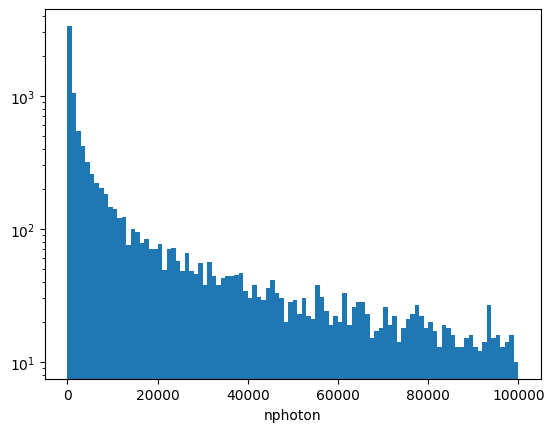

In [ ]:
h = plt.hist(data['nphoton'], bins=100, range=(0, 100000))
plt.xlabel('nphoton')
plt.yscale('log')

In [ ]:
n =10
event = {}
for name, dataset in data.items():
    if len(dataset) > n:  # Check if n-th entry exists
        event[name] = dataset[n]
    else:
        event[name] = None  # or some default value if n-th entry doesn't exist


In [ ]:
event['pmt_bot']

array([[58, 52],
       [78, 83]], dtype=int32)

In [ ]:
import numpy as np
import h5py

class EventReader:
    
    def __init__(self, filenames):
        self.data_dict = self._load_data(filenames)
        self.num_events = len(next(iter(self.data_dict.values())))  # assuming all datasets have the same length
        print(self.num_events)
    
    def _load_data(self, filenames):
        data_dicts = []
        
        for filename in filenames:
            with h5py.File(filename, 'r') as f:
                group = f['events']
                data_dict = {name: np.array(dataset) for name, dataset in group.items()}
                data_dicts.append(data_dict)
        
        # Now, concatenate arrays from all dictionaries along the first axis (events)
        # Start with the first dictionary and update it with concatenated arrays from other dictionaries
        combined_data = data_dicts[0]
        for key in combined_data.keys():
            combined_data[key] = np.concatenate([d[key] for d in data_dicts], axis=0)
        
        return combined_data

    def get_event(self, n):
        if n >= self.num_events:
            raise IndexError("Event index out of range")
        
        return {name: dataset[n] for name, dataset in self.data_dict.items()}

    # any other methods you need...



In [ ]:
er = EventReader(files)
for i in range(er.num_events):
    if i%10000 == 0:
        print('processed ',i,'events')
    event = er.get_event(i)


1000000
processed  0 events
processed  10000 events
processed  20000 events
processed  30000 events
processed  40000 events
processed  50000 events
processed  60000 events
processed  70000 events
processed  80000 events
processed  90000 events
processed  100000 events
processed  110000 events
processed  120000 events
processed  130000 events
processed  140000 events
processed  150000 events
processed  160000 events
processed  170000 events
processed  180000 events
processed  190000 events
processed  200000 events
processed  210000 events
processed  220000 events
processed  230000 events
processed  240000 events
processed  250000 events
processed  260000 events
processed  270000 events
processed  280000 events
processed  290000 events
processed  300000 events
processed  310000 events
processed  320000 events
processed  330000 events
processed  340000 events
processed  350000 events
processed  360000 events
processed  370000 events
processed  380000 events
processed  390000 events
proces

In [ ]:
data

[]